In [ ]:
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

In [115]:
import math
import os
import tempfile

import pandas as pd
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, ForecastDFDataset
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
from sklearn.preprocessing import LabelEncoder, StandardScaler
from typing import Tuple
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [116]:
os.listdir()

['.config',
 'testing_dataset.csv',
 'training_dataset.csv',
 'predictions',
 'ttm_finetuned_models',
 'sample_data']

### Variables

In [158]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

label_encoder = LabelEncoder()
scaler = StandardScaler()

In [159]:
# Dataset
TARGET_DATASET = "datavidia"
# dataset_path = "./AdditionalDataset/training_dataset.csv"
# test_dataset_path = "./AdditionalDataset/testing_dataset.csv"
dataset_path = "./training_dataset.csv"
test_dataset_path = "./testing_dataset.csv"
timestamp_column = "Date"
id_columns = ['commodity', 'province']
target_columns = ['price']
split_config = {
    "train": 0.8,
    "test": 0.1
}

test_split_config = {
    "train": 0.8,
    "test": 0.1
}

# Understanding the split config -- slides

feature_to_scale = ['GlobalOpen', 'GlobalHigh', 'GlobalVol.', 'GlobalPrice', 'CE_Close', 'CE_High', 'CE_Low', 'CE_Open']

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

test_data = pd.read_csv(
    test_dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

### Data Preparation

In [160]:
def process_dataset(df: pd.DataFrame):
    df['Date'] = pd.to_datetime(df['Date'])
    df['timestamp'] = df['Date'].astype(int)
    df['timestamp'] = df['timestamp'].div(10**9)

    df['province'] = label_encoder.fit_transform(df['province'])
    df['commodity'] = label_encoder.fit_transform(df['commodity'])

    df = df.drop(columns=['Unnamed: 0'])

    for col in feature_to_scale:
        df[col] = scaler.fit_transform(df[[col]])
    return df

In [161]:
data = process_dataset(data)
test_data = process_dataset(test_data)

In [162]:
data.head()

,Date,commodity,province,price,GlobalOpen,GlobalHigh,GlobalLow,GlobalVol.,GlobalChange %,GlobalPrice,CE_Close,CE_High,CE_Low,CE_Open,timestamp
0,2022-01-01,0,0,28970.0,0.384917,0.977176,3.5,-1.266524,-0.48,0.316524,-1.932679,-1.862012,1.437183,-1.87819,1.640995e+09
1,2022-01-01,1,0,27440.0,0.384917,0.977176,3.5,-1.266524,-0.48,0.316524,-1.932679,-1.862012,1.437183,-1.87819,1.640995e+09
2,2022-01-01,2,0,11030.0,0.384917,0.977176,3.5,-1.266524,-0.48,0.316524,-1.932679,-1.862012,1.437183,-1.87819,1.640995e+09
3,2022-01-01,3,0,12080.0,0.384917,0.977176,3.5,-1.266524,-0.48,0.316524,-1.932679,-1.862012,1.437183,-1.87819,1.640995e+09
4,2022-01-01,4,0,22360.0,0.384917,0.977176,3.5,-1.266524,-0.48,0.316524,-1.932679,-1.862012,1.437183,-1.87819,1.640995e+09


In [163]:
test_data['price'] = 0
len(test_data)

40664

### Fine Tuned Model

In [294]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
) -> Trainer:
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_val, dset_test = get_datasets(
        tsp, data, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=1,
            loss=loss,
            quantile=quantile,
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    backbone_embedding = predictions_dict.predictions[1]

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        channel=0,
    )

    return finetune_forecast_trainer, tsp

-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,1.004100,0.719330


[TrackingCallback] Mean Epoch Time = 3.915142297744751 seconds, Total Train Time = 6.891835451126099
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.6005375981330872, 'eval_runtime': 2.6579, 'eval_samples_per_second': 217.465, 'eval_steps_per_second': 7.148, 'epoch': 1.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


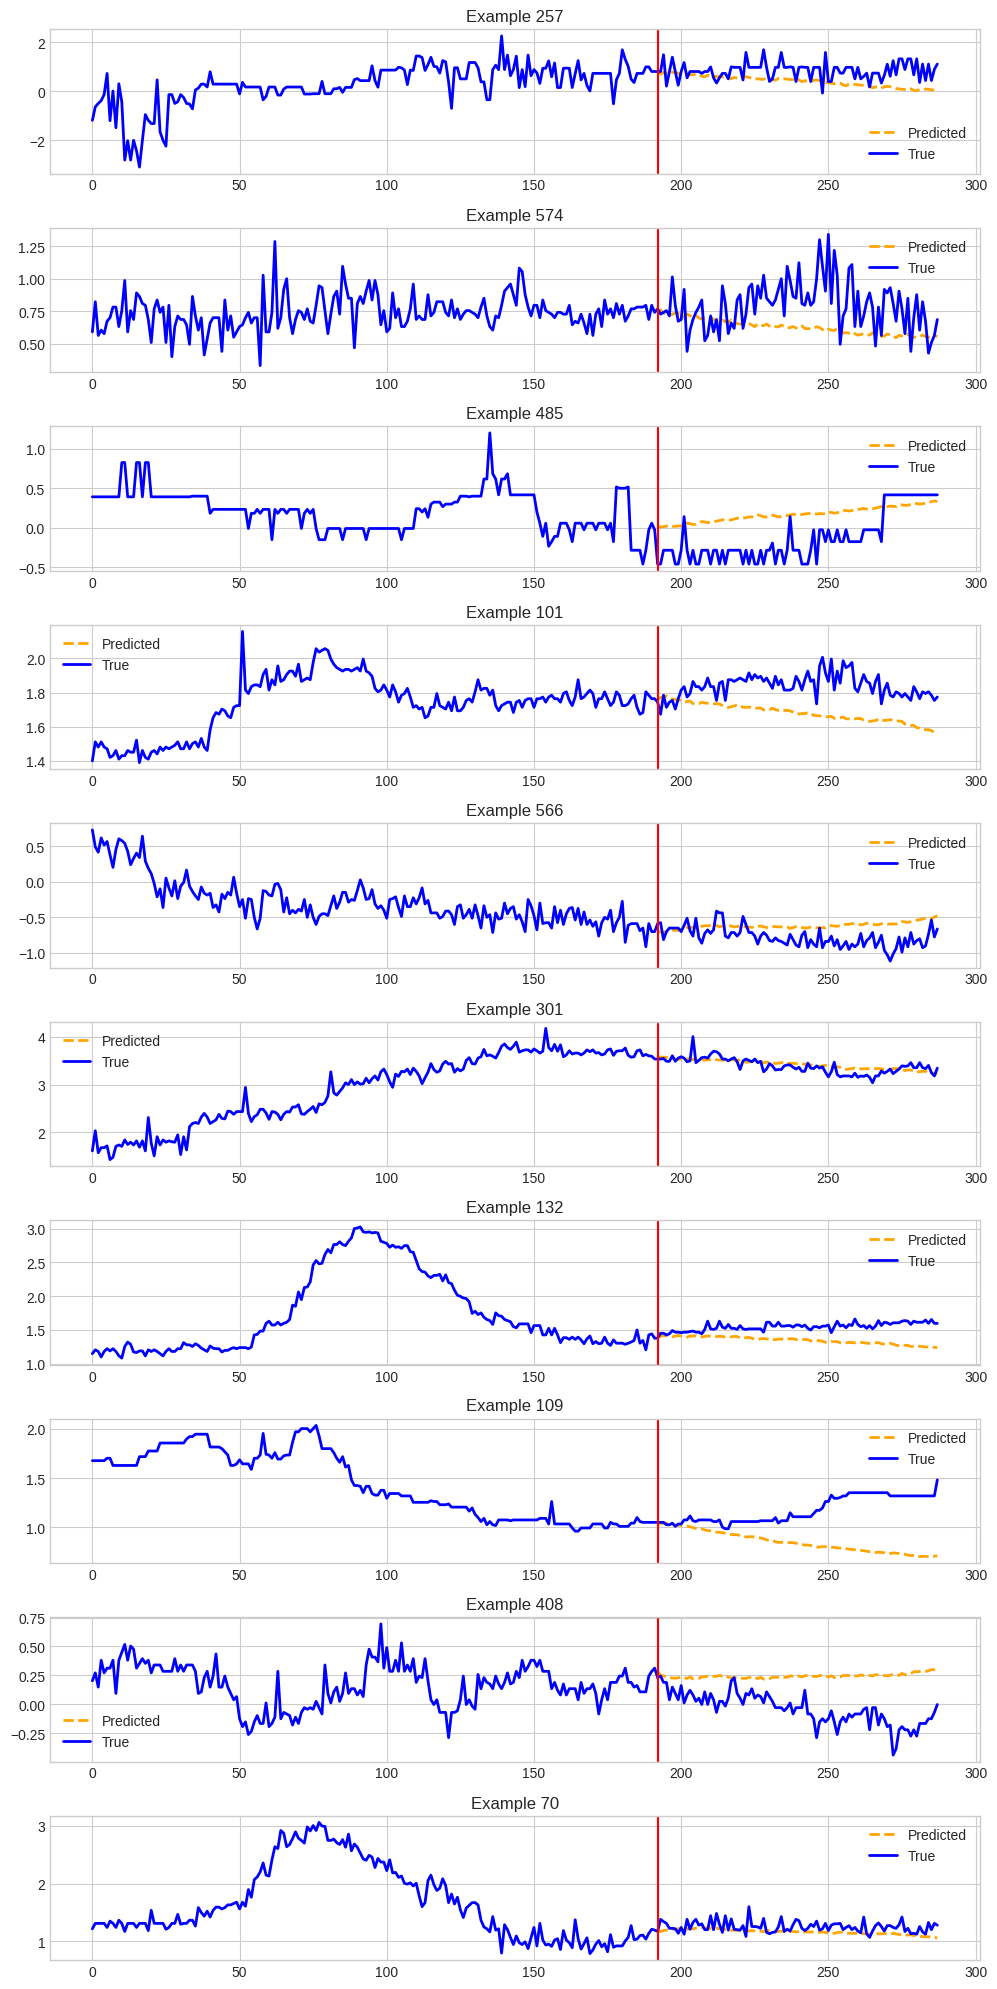

In [295]:
# fewshot_finetune_eval(
#     dataset_name=TARGET_DATASET,
#     context_length=CONTEXT_LENGTH,
#     forecast_length=PREDICTION_LENGTH,
#     batch_size=32,
#     fewshot_percent=30,
#     learning_rate=0.001,
#     num_epochs=20
# )

finetuned_trainer, tsp = fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=32,
    fewshot_percent=5,
    learning_rate=0.001,
    num_epochs=1
)

### Test Model

In [296]:
def create_single_dataset(
    ts_preprocessor: TimeSeriesPreprocessor,
    dataset: pd.DataFrame,
    stride: int = 1,
    use_frequency_token: bool = False,
    enable_padding: bool = True,
    **dataset_kwargs
) -> ForecastDFDataset:
    """Creates a single preprocessed pytorch dataset without splitting

    Args:
        ts_preprocessor (TimeSeriesPreprocessor): The preprocessor object that has been initialized
        dataset (pd.DataFrame): Your pandas dataframe containing time series data
        stride (int): Stride used for creating the dataset. Defaults to 1.
        use_frequency_token (bool): If True, dataset is created with frequency token. Defaults to False.
        enable_padding (bool): If True, dataset is created with padding. Defaults to True.
        dataset_kwargs: Additional keyword arguments to pass to the torch dataset.

    Returns:
        A pytorch dataset ready for use
    """

    if not ts_preprocessor.context_length:
        raise ValueError("TimeSeriesPreprocessor must be instantiated with non-null context_length")
    if not ts_preprocessor.prediction_length:
        raise ValueError("TimeSeriesPreprocessor must be instantiated with non-null prediction_length")

    # Standardize the dataframe
    data = ts_preprocessor._standardize_dataframe(dataset)

    # # Train the preprocessor on the full dataset
    # ts_preprocessor.train(data)

    # Preprocess the data
    preprocessed_data = ts_preprocessor.preprocess(data)

    # Specify columns
    params = {
        "id_columns": ts_preprocessor.id_columns,
        "timestamp_column": ts_preprocessor.timestamp_column,
        "target_columns": ts_preprocessor.target_columns,
        "observable_columns": ts_preprocessor.observable_columns,
        "control_columns": ts_preprocessor.control_columns,
        "conditional_columns": ts_preprocessor.conditional_columns,
        "categorical_columns": ts_preprocessor.categorical_columns,
        "static_categorical_columns": ts_preprocessor.static_categorical_columns,
        "context_length": ts_preprocessor.context_length,
        "prediction_length": ts_preprocessor.prediction_length,
        "stride": stride,
        "enable_padding": enable_padding
    }

    # Add frequency token if needed
    if use_frequency_token:
        params["frequency_token"] = ts_preprocessor.get_frequency_token(ts_preprocessor.freq)

    # Add any additional parameters
    params.update(**dataset_kwargs)

    # Create and return the dataset
    final_dataset = ForecastDFDataset(preprocessed_data, **params)

    if len(final_dataset) == 0:
        raise RuntimeError("Generated dataset is of zero length.")

    return final_dataset

In [302]:
def predict_new_data(
    trainer,
    new_data: pd.DataFrame,
    tsp: TimeSeriesPreprocessor,
    context_length: int = 512,
    forecast_length: int = 92,
    dataset_name: str = "new_dataset",
    save_dir: str = "./predictions",
    with_plot: bool = True,
    channel: int = 0
) -> Tuple[pd.DataFrame, np.ndarray, object]:
    """
    Make predictions on new data using a previously trained model and return a DataFrame
    with predictions for each row.

    Args:
        trainer: Trained model used for prediction.
        new_data: DataFrame containing new data for prediction.
        column_specifiers: Column mappings for TimeSeriesPreprocessor.
        context_length: Context length for the model.
        forecast_length: Forecast length for the model.
        dataset_name: Name for saving predictions.
        save_dir: Directory for saving results.
        id_columns: Identifying columns (Date, commodity, province).
        timestamp_column: Column containing timestamps.
        with_plot: Whether to generate plots.
        channel: Channel to plot.

    Returns:
        Tuple of (predictions_df, raw_predictions, test_dataset)
    """

    # Create output directory
    out_dir = os.path.join(save_dir, dataset_name)
    os.makedirs(out_dir, exist_ok=True)

    # Create the test dataset
    test_dataset = create_single_dataset(
        ts_preprocessor=tsp,
        dataset=new_data,
        stride=1,  # Ensure full dataset coverage
        use_frequency_token=False,
        enable_padding=True
    )
    print(f'New data test dataset length: {len(test_dataset)}')

    # Extract identifier values for each sample
    original_indices = []
    id_values_list = []

    for i in range(len(test_dataset)):
        sample = test_dataset[i]
        # print(sample.keys())
        # return
        id_values = {col: sample["id"][j] for j, col in enumerate(id_columns)}

        id_values_list.append(id_values)
        original_indices.append(i)

    # Set model to evaluation mode
    trainer.model.eval()

    # Set loss function (if needed)
    trainer.model.loss = "mse"

    # Run prediction
    predictions_dict = trainer.predict(test_dataset)

    predictions_np = predictions_dict.predictions[0]  # Extract forecasted values

    # Extract backbone embeddings (optional)
    if len(predictions_dict.predictions) > 1:
        backbone_embedding = predictions_dict.predictions[1]

    # Extracting forecasted prices
    rows = []

    for i, idx in enumerate(original_indices):
        if i >= len(predictions_np):
            print(f"Warning: No prediction available for index {idx}")
            continue

        id_values = id_values_list[i]

        # Generate the date sequence for the forecast period
        start_date = pd.to_datetime("2024-10-01")
        forecast_dates = [start_date + pd.Timedelta(days=step) for step in range(predictions_np.shape[1])]

        for step, date in enumerate(forecast_dates):
            row = {
                "date": date.strftime("%Y-%m-%d"),
                "commodity": id_values["commodity"],
                "province": id_values["province"],
                "price": predictions_np[i, step, 0],  # Extract price for step
            }
            rows.append(row)


    # Convert to DataFrame
    predictions_df = pd.DataFrame(rows)

    # Apply inverse scaling
    predictions_df = tsp.inverse_scale_targets(predictions_df)

    # Save predictions
    predictions_df.to_csv(os.path.join(out_dir, f"{dataset_name}_formatted_predictions.csv"), index=False)

    # Plot predictions if enabled
    if with_plot:
        plot_predictions(
            model=trainer.model,
            dset=test_dataset,
            plot_dir=out_dir,
            plot_prefix=f"{dataset_name}_predictions",
            channel=channel,
        )

    return predictions_df, predictions_np, test_dataset

In [303]:
len(set(test_data['Date']))

92

In [304]:
test_data.columns

Index(['Date', 'commodity', 'province', 'GlobalOpen', 'GlobalHigh',
       'GlobalLow', 'GlobalVol.', 'GlobalChange %', 'GlobalPrice', 'CE_Close',
       'CE_High', 'CE_Low', 'CE_Open', 'timestamp', 'price'],
      dtype='object')

In [305]:
len(test_data)

40664

New data test dataset length: 442


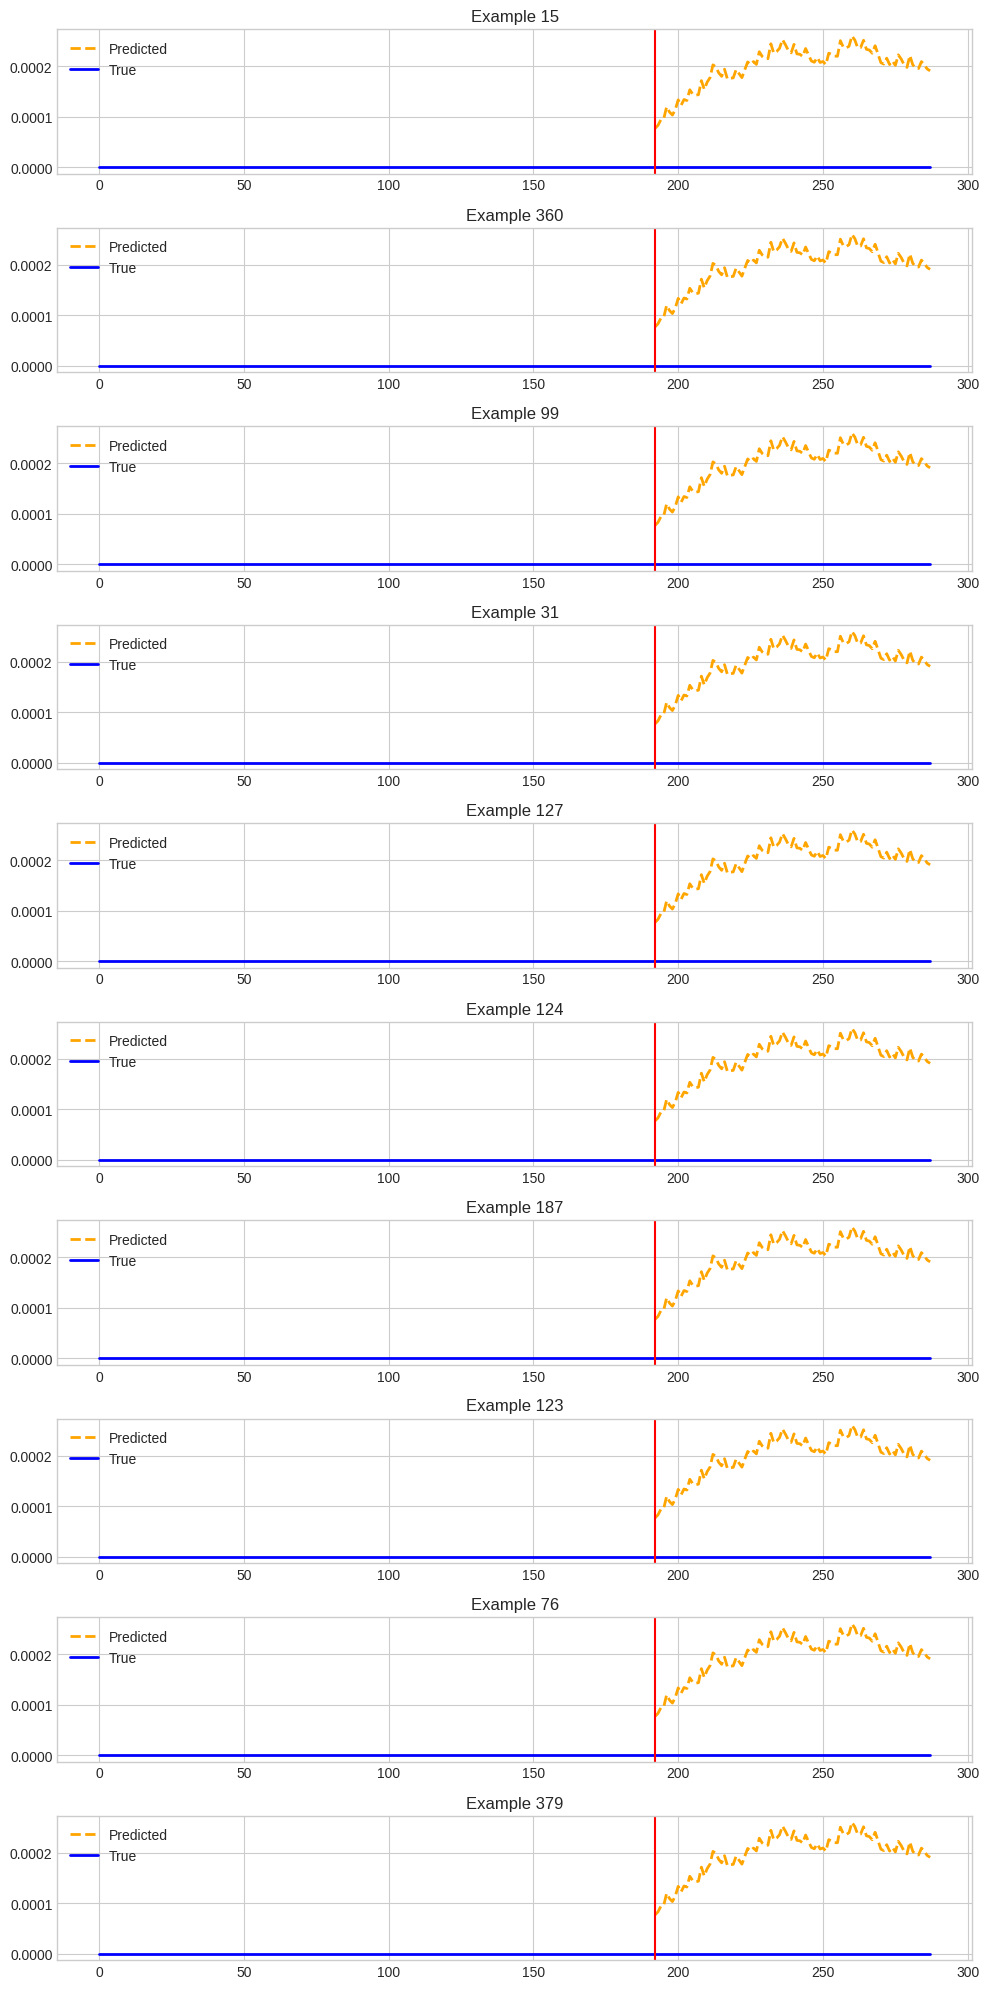

In [331]:
predictions_df, _, _ = predict_new_data(
    trainer=finetuned_trainer,
    new_data=test_data,
    tsp=tsp,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    dataset_name="new_prediction",
    with_plot=True
)

In [323]:
predictions_df.head(10)

,date,commodity,province,price
0,2024-10-01,0,0,33329.933594
1,2024-10-02,0,0,33329.964844
2,2024-10-03,0,0,33330.019531
3,2024-10-04,0,0,33330.031250
4,2024-10-05,0,0,33330.152344
5,2024-10-06,0,0,33330.097656
6,2024-10-07,0,0,33330.070312
7,2024-10-08,0,0,33330.125000
8,2024-10-09,0,0,33330.222656
9,2024-10-10,0,0,33330.167969


In [326]:
len(predictions_df)

42432

In [329]:
filtered_df = predictions_df[predictions_df["date"] < "2025-01-01"]

In [330]:
len(filtered_df)

40664